In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fsolve, root

Let's declare a bunch of constants

In [2]:
# 1D EDO for Fold bifurcation paramaters
a1 = -1
a2 = 1

# 2D EDO for Hopf bifurcation parameters
b1 = b2 = 1
c1 = -1
c2 = 1

# initial conditions
x0 = 0.0
y0 = 5.0
z0 = 5.0

r0 = 5.0

# time range
t_init = 0
t_fin = 500
time_step = 0.01

Let's write our EDOs

In [17]:
# linear coupling parameter
# proposed by Dekker et al. article
def gamma(x):
    return (-0.1 + 0.12*x)

def fold(v, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi
  ])

def hopf(v, phi):
  return np.array([
    phi * v[0] - (v[0] ** 3),
  ])

def hopf_coupled(v, gamma, phi):
  rsquared = v[1] ** 2 + v[2] ** 2
  return np.array([
    gamma(v[0]) * rsquared - (rsquared ** 3)
  ])

# v is a vector \vec{v}: [x, y, z]
def fold_hopf_polar(v, gamma, phi):
  rsquared = v[1] ** 2 + v[2] ** 2
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    gamma(v[0]) * rsquared - (rsquared ** 3)
  ])

# v is a vector \vec{v}: [x, y, z]
def fold_hopf(v, gamma, phi):
  return np.array([
    a1 * (v[0] ** 3) + a2 * v[0] + phi,
    b1*v[2] + b2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[1],
    c1*v[1] + c2*(gamma(v[0]) - (v[1]**2 + v[2]**2))*v[2]
  ])

We use RK4 method to solve our non-linear systems of EDOs

In [4]:
def rk4_derivatives(edo, time_step, v, *args):
  k1 = edo(v, *args)
  k2 = edo(v + ((time_step / 2) * k1), *args)
  k3 = edo(v + ((time_step / 2) * k2), *args)
  k4 = edo(v + (time_step * k3), *args)
  return (k1 + 2*k2 + 2*k3 + k4)

def rk4(edo, time_step, v, *args):
  return (time_step / 6) * rk4_derivatives(edo, time_step, v, *args)

Time serie

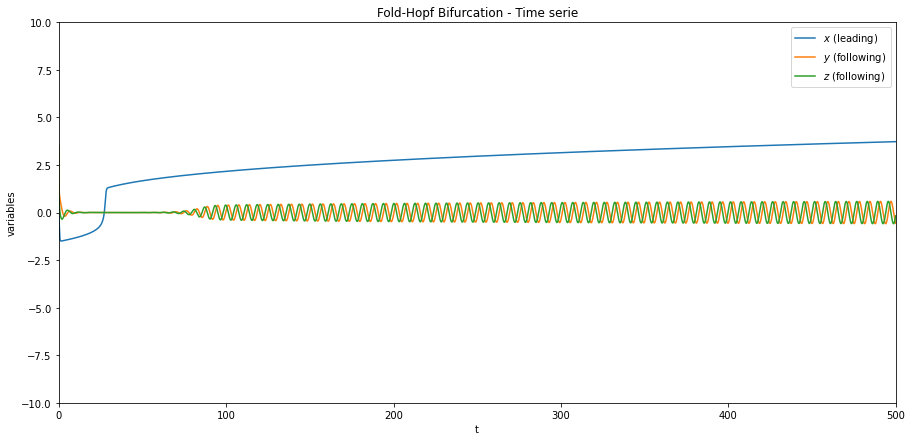

In [5]:
class time_series():
  def __init__(self):
    # initial conditions
    self.initial_conditions = np.array([[x0, y0, z0]])
    # forcing parameter
    self.phi = -2
    # time
    self.t_init = t_init
    self.t_fin = t_fin
    self.time_step = time_step
    # data
    self.dataset = self.initial_conditions
    self.time_range = np.arange(t_init, t_fin + time_step, time_step)
    self.legends = ["$x$ (leading)", "$y$ (following)", "$z$ (following)"]


  def rk4(self):
    # [x0, y0, z0]
    v = self.initial_conditions[0]

    for t in self.time_range:
      if t == self.t_fin: break # LOL

      # increase forcing parameter
      self.phi += 0.001

      v += rk4(fold_hopf, self.time_step, v, gamma, self.phi)
      self.dataset = np.append(self.dataset, [v.copy()], axis=0)

    self.plot()

  def plot(self):
    fig, ax = plt.subplots(figsize=(15, 7))

    l1, = ax.plot(self.time_range, self.dataset[:,0])
    l2, = ax.plot(self.time_range, self.dataset[:,1])
    l3, = ax.plot(self.time_range, self.dataset[:,2])

    plt.xlabel("t")
    plt.ylabel("variables")
    plt.xlim(0,500)
    plt.ylim(-10,10)
    plt.legend(self.legends, loc="upper right")
    plt.title("Fold-Hopf Bifurcation - Time serie")
    plt.show()

time_serie = time_series()
time_serie.rk4()

Let's do our bifurcations

/Users/mathieu/Lab/computational-physics/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/mathieu/Lab/computational-physics/env/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


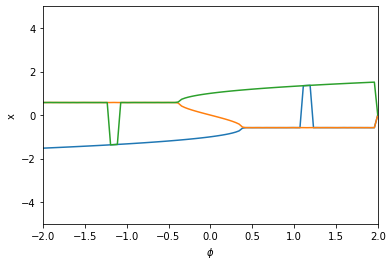

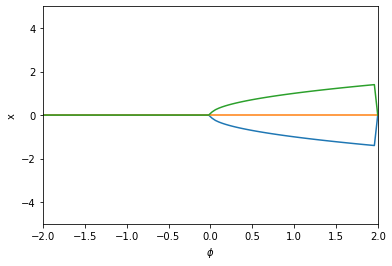

/Users/mathieu/Lab/computational-physics/env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'hopf_coupled'.Shape should be (3,) but it is (1, 1).

In [18]:
phi = 0
nphi = 100
nguesses = 3
phi_mesh = np.linspace(start=-2, stop=2, num=nphi)

# number of time steps
nt = int((t_fin - t_init) / time_step)
time_mesh = np.linspace(start=t_init, stop=t_fin, num=nt)

def fold_bifurcation():
    equilibria_mesh = np.zeros((nphi, nguesses))

    # for each phi
    for phi_index in range(0, nphi-1):
      # # create mesh
      # x = np.zeros(self.nt)
      # # set initial conditions (for each phi value)
      # x[0] = x0

      # # simulate the system over time
      # for t in range(0, self.nt-1):
      #   x[t+1] = rk4(fold, time_step, t, x, self.phi_mesh[phi_index])

      # find the equilibria of our system
      guesses = np.linspace(start=-3, stop=3, num=nguesses)
      equilibria = []
      
      # look for some equilibria
      for guess in guesses:  
          equilibrium = fsolve(func=fold, x0=[guess], args=(phi_mesh[phi_index]))
          equilibria.append(equilibrium[0])
      
      np.array([equilibria])
      # add to the mesh
      #print(np.shape(equilibria_mesh[phi_index]), np.shape(equilibria))
        
      equilibria_mesh[phi_index] = np.array([equilibria])

    plot(equilibria_mesh.copy())

def hopf_bifurcation():
    equilibria_mesh = np.zeros((nphi, nguesses))

    # for each phi
    for phi_index in range(0, nphi-1):
      # create mesh
      # x = np.zeros(self.nt)
      # # set initial conditions (for each phi value)
      # x[0] = x0

      # # simulate the system over time
      # for t in range(0, self.nt-1):
      #   x[t+1] = rk4(fold, time_step, t, x, self.phi_mesh[phi_index])
      # jacobian matrix df(p)
      #jac = 

      guesses = np.linspace(start=-3, stop=3, num=nguesses)
      equilibria = []
      
      # look for some equilibria
      for guess in guesses:  
          equilibrium = fsolve(func=hopf, x0=[guess], args=(phi_mesh[phi_index]))
          equilibria.append(equilibrium[0])

      # add to the mesh
      equilibria_mesh[phi_index] = equilibria

    plot(equilibria_mesh.copy())
    

def fold_hopf_bifurcation():
    equilibria_mesh = np.zeros((nphi, nguesses))

    # for each phi
    for phi_index in range(0, nphi-1):
      # create mesh
      # x = np.zeros(self.nt)
      # # set initial conditions (for each phi value)
      # x[0] = x0

      # # simulate the system over time
      # for t in range(0, self.nt-1):
      #   x[t+1] = rk4(fold, time_step, t, x, self.phi_mesh[phi_index])
      # jacobian matrix df(p)
      #jac = 

      guesses = np.linspace(start=-3, stop=3, num=nguesses)
      equilibria = []
      
      # look for some equilibria
      for guess in guesses:  
          equilibrium_fold = fsolve(func=fold, x0=[guess], args=(phi_mesh[phi_index]))
          equilibrium_hopf_coupled = fsolve(func=hopf_coupled, x0=[equilibrium_fold, guess, guess], args=(gamma, phi_mesh[phi_index]))
          equilibria.append(equilibrium_fold[0])
          equilibria.append(equilibrium_hopf_coupled[0])

      # add to the mesh
      equilibria_mesh[phi_index] = equilibria

    plot(equilibria_mesh.copy())

def plot(dataset):
    plt.plot(phi_mesh, dataset)
    plt.xlabel("$\phi$")
    plt.ylabel("x")
    plt.xlim(-2,2)
    plt.ylim(-5,5)
    plt.show()
    
fold_bifurcation()
hopf_bifurcation()
fold_hopf_bifurcation()